#### CSC 180 Intelligent Systems 

#### California State University, Sacramento



## Lab 8: Hyper-parameter Tuning for Backpropagation and Dropout


# Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


# Learning rate
Backpropagation is the primary means by which a neural network's weights are determined during training. Backpropagation works by calculating a weight change amount ($v_t$) for every weight($\theta$, theata) in the neural network.  This value is subtracted from every weight by the following equation: 

$ \theta_t = \theta_{t-1} - v_t $


### The learning rate is an important concept for backpropagation training.  Setting the learning rate can be complex:

* Too low of a learning rate will usually converge to a good solution; however, the process will be very slow.
* Too high of a learning rate will either fail outright, or converge to a higher error than a better learning rate.

#### Common values for learning rate are: 0.1, 0.01, 0.001, etc.


# Batch size

#### Number of samples per gradient update.  In keras, you may set the batch_size parameter in function fit()

https://keras.io/models/model/

batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.

# Update rules (optimizers)

The following image shows how each of these algorithms train (image credits: [author](http://sebastianruder.com/optimizing-gradient-descent/index.html#visualizationofalgorithms) ):

![Training Techniques](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/contours_evaluation_optimizers.gif "Training Techniques")


### An optimizer is one of the two arguments required when you compile a Keras model using compile(). 

Specifying the Update Rule (Optimizer) in Tensorflow

TensorFlow allows the update rule to be set to one of:

* Adagrad
* **Adam**
* Ftrl
* Momentum
* RMSProp
* **SGD**

https://keras.io/optimizers/


### You can either instantiate an optimizer or you can call it by its name. In the latter case, the default parameters for the optimizer will be used.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(10, input_dim=10, activation='relu'))
model.add(Dense(1))

sgd = optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

#adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='mean_squared_error', optimizer=sgd)

#### Using all Default Parameters for a Particular Optimizer

In [3]:
# pass optimizer by name: default parameters will be used
model.compile(loss='mean_squared_error', optimizer='sgd')

## A Complete Example:

Note: you may need to restart the kernel to use updated packages.
Epoch 1/1000


ERROR: Could not find a version that satisfies the requirement sklearn.model_selection (from versions: none)
ERROR: No matching distribution found for sklearn.model_selection


3/3 - 0s - loss: 614.1690 - val_loss: 581.6932 - 276ms/epoch - 92ms/step
Epoch 2/1000
3/3 - 0s - loss: 613.5857 - val_loss: 580.9929 - 29ms/epoch - 10ms/step
Epoch 3/1000
3/3 - 0s - loss: 612.9793 - val_loss: 580.2787 - 27ms/epoch - 9ms/step
Epoch 4/1000
3/3 - 0s - loss: 612.3602 - val_loss: 579.5546 - 27ms/epoch - 9ms/step
Epoch 5/1000
3/3 - 0s - loss: 611.7428 - val_loss: 578.8172 - 27ms/epoch - 9ms/step
Epoch 6/1000
3/3 - 0s - loss: 611.1277 - val_loss: 578.0760 - 28ms/epoch - 9ms/step
Epoch 7/1000
3/3 - 0s - loss: 610.4713 - val_loss: 577.3245 - 27ms/epoch - 9ms/step
Epoch 8/1000


c:\Users\cdub6\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 - 0s - loss: 609.8473 - val_loss: 576.5609 - 28ms/epoch - 9ms/step
Epoch 9/1000
3/3 - 0s - loss: 609.1882 - val_loss: 575.7970 - 27ms/epoch - 9ms/step
Epoch 10/1000
3/3 - 0s - loss: 608.5323 - val_loss: 575.0112 - 28ms/epoch - 9ms/step
Epoch 11/1000
3/3 - 0s - loss: 607.8527 - val_loss: 574.2212 - 26ms/epoch - 9ms/step
Epoch 12/1000
3/3 - 0s - loss: 607.1767 - val_loss: 573.4233 - 28ms/epoch - 9ms/step
Epoch 13/1000
3/3 - 0s - loss: 606.4797 - val_loss: 572.6107 - 28ms/epoch - 9ms/step
Epoch 14/1000
3/3 - 0s - loss: 605.7960 - val_loss: 571.7892 - 28ms/epoch - 9ms/step
Epoch 15/1000
3/3 - 0s - loss: 605.0913 - val_loss: 570.9653 - 27ms/epoch - 9ms/step
Epoch 16/1000
3/3 - 0s - loss: 604.3938 - val_loss: 570.1323 - 27ms/epoch - 9ms/step
Epoch 17/1000
3/3 - 0s - loss: 603.6861 - val_loss: 569.2923 - 27ms/epoch - 9ms/step
Epoch 18/1000
3/3 - 0s - loss: 602.9537 - val_loss: 568.4308 - 27ms/epoch - 9ms/step
Epoch 19/1000
3/3 - 0s - loss: 602.1961 - val_loss: 567.5518 - 27ms/epoch - 9ms/

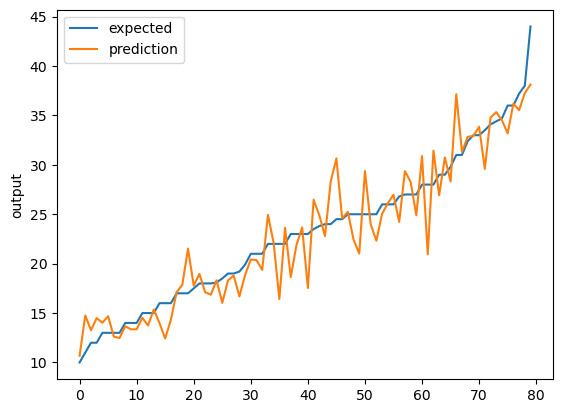

In [8]:
#%pip install matplotlib
%pip install sklearn.model_selection
%matplotlib inline
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

path = "./data/"
preprocess = True

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
encode_text_dummy(df, 'origin')
df.drop('name',axis=1,inplace=True) 
if preprocess:
    encode_numeric_zscore(df, 'horsepower')
    encode_numeric_zscore(df, 'weight')
    encode_numeric_zscore(df, 'cylinders')
    encode_numeric_zscore(df, 'displacement')
    encode_numeric_zscore(df, 'acceleration')
    encode_numeric_zscore(df, 'year')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
 
model.add(Dense(1, activation='relu'))

adam = optimizers.legacy.Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adam)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

# batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)

### Next we vary the optimizer paramters (SGD) and batch size (32) 

Epoch 1/1000
10/10 - 0s - loss: 617.5059 - val_loss: 586.1075 - 260ms/epoch - 26ms/step
Epoch 2/1000
10/10 - 0s - loss: 614.3199 - val_loss: 579.9825 - 32ms/epoch - 3ms/step
Epoch 3/1000
10/10 - 0s - loss: 603.6915 - val_loss: 564.0189 - 32ms/epoch - 3ms/step
Epoch 4/1000
10/10 - 0s - loss: 586.5067 - val_loss: 542.9383 - 32ms/epoch - 3ms/step
Epoch 5/1000
10/10 - 0s - loss: 564.5894 - val_loss: 517.3763 - 32ms/epoch - 3ms/step
Epoch 6/1000
10/10 - 0s - loss: 538.2240 - val_loss: 485.2387 - 30ms/epoch - 3ms/step
Epoch 7/1000
10/10 - 0s - loss: 499.6762 - val_loss: 439.4349 - 31ms/epoch - 3ms/step


c:\Users\cdub6\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 8/1000
10/10 - 0s - loss: 438.3180 - val_loss: 366.0946 - 31ms/epoch - 3ms/step
Epoch 9/1000
10/10 - 0s - loss: 345.8995 - val_loss: 255.9290 - 32ms/epoch - 3ms/step
Epoch 10/1000
10/10 - 0s - loss: 212.2958 - val_loss: 121.7471 - 31ms/epoch - 3ms/step
Epoch 11/1000
10/10 - 0s - loss: 80.9846 - val_loss: 34.6621 - 31ms/epoch - 3ms/step
Epoch 12/1000
10/10 - 0s - loss: 28.6889 - val_loss: 24.3461 - 31ms/epoch - 3ms/step
Epoch 13/1000
10/10 - 0s - loss: 25.0209 - val_loss: 23.5961 - 31ms/epoch - 3ms/step
Epoch 14/1000
10/10 - 0s - loss: 21.7060 - val_loss: 18.6022 - 32ms/epoch - 3ms/step
Epoch 15/1000
10/10 - 0s - loss: 18.6921 - val_loss: 16.5299 - 31ms/epoch - 3ms/step
Epoch 16/1000
10/10 - 0s - loss: 17.5967 - val_loss: 15.3550 - 32ms/epoch - 3ms/step
Epoch 17/1000
10/10 - 0s - loss: 16.7688 - val_loss: 14.4380 - 31ms/epoch - 3ms/step
Epoch 18/1000
10/10 - 0s - loss: 16.0814 - val_loss: 13.6805 - 31ms/epoch - 3ms/step
Epoch 19/1000
10/10 - 0s - loss: 15.4819 - val_loss: 12.9994 

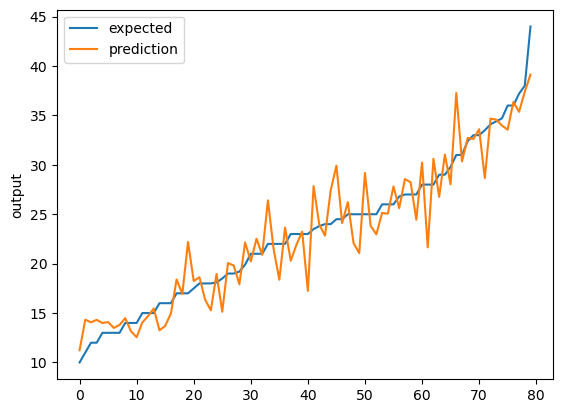

In [5]:
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
 
model.add(Dense(1, activation='relu'))

sgd = optimizers.legacy.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)   # much smaller lr
model.compile(loss='mean_squared_error', optimizer=sgd)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

# batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)



## Dropout Layer  (A dedicated layer for regularization)

#### A dropout layer can be added between any two hidden layers to reduce overfitting.   A certain percentage of neurons will be masked during each training iteration. 

*** To create a dropout layer, specify dropout probability.   ***  The dropout probability indicates the likelihood of a neuron dropping out for every batch during training. Typically this value is 0.1 to 0.5. 

Let's add some dropout


Epoch 1/1000


10/10 - 0s - loss: 606.1035 - val_loss: 555.6003 - 293ms/epoch - 29ms/step
Epoch 2/1000
10/10 - 0s - loss: 553.4946 - val_loss: 486.2678 - 35ms/epoch - 3ms/step
Epoch 3/1000
10/10 - 0s - loss: 455.8268 - val_loss: 364.6081 - 35ms/epoch - 3ms/step
Epoch 4/1000
10/10 - 0s - loss: 303.2034 - val_loss: 199.6223 - 32ms/epoch - 3ms/step
Epoch 5/1000
10/10 - 0s - loss: 138.3301 - val_loss: 86.7085 - 34ms/epoch - 3ms/step
Epoch 6/1000
10/10 - 0s - loss: 68.5666 - val_loss: 66.4570 - 33ms/epoch - 3ms/step


c:\Users\cdub6\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 7/1000
10/10 - 0s - loss: 56.1716 - val_loss: 52.0548 - 35ms/epoch - 3ms/step
Epoch 8/1000
10/10 - 0s - loss: 42.3287 - val_loss: 33.1398 - 34ms/epoch - 3ms/step
Epoch 9/1000
10/10 - 0s - loss: 28.2291 - val_loss: 22.1927 - 33ms/epoch - 3ms/step
Epoch 10/1000
10/10 - 0s - loss: 22.6335 - val_loss: 16.1437 - 33ms/epoch - 3ms/step
Epoch 11/1000
10/10 - 0s - loss: 18.0318 - val_loss: 13.5773 - 33ms/epoch - 3ms/step
Epoch 12/1000
10/10 - 0s - loss: 17.5908 - val_loss: 12.3890 - 33ms/epoch - 3ms/step
Epoch 13/1000
10/10 - 0s - loss: 16.2985 - val_loss: 11.7721 - 33ms/epoch - 3ms/step
Epoch 14/1000
10/10 - 0s - loss: 16.7911 - val_loss: 11.2177 - 32ms/epoch - 3ms/step
Epoch 15/1000
10/10 - 0s - loss: 15.3855 - val_loss: 10.5186 - 34ms/epoch - 3ms/step
Epoch 16/1000
10/10 - 0s - loss: 16.4763 - val_loss: 10.0147 - 32ms/epoch - 3ms/step
Epoch 17/1000
10/10 - 0s - loss: 14.6892 - val_loss: 9.6755 - 33ms/epoch - 3ms/step
Epoch 18/1000
10/10 - 0s - loss: 14.7718 - val_loss: 9.2381 - 33ms/ep

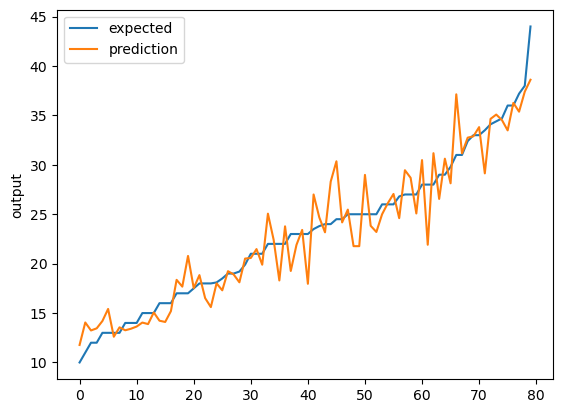

In [6]:
from tensorflow.keras.layers import Dense, Activation, Dropout


model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu')) #changed to 100

model.add(Dropout(0.1)) 

model.add(Dense(1, activation='relu'))


sgd = optimizers.legacy.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)   # much smaller lr
model.compile(loss='mean_squared_error', optimizer=sgd)


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

# batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 32, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten(),y_test)



### References:

* [Google Colab](https://colab.research.google.com/) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow with free GPU support.  No setup needed.
* [IBM Cognitive Class Labs](https://www.datascientistworkbench.com) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow.  No setup needed.
* [Python Anaconda](https://www.continuum.io/downloads) - Python distribution that includes many data science packages, such as Numpy, Scipy, Scikit-Learn, Pandas, and much more.
* [TensorFlow](https://www.tensorflow.org/) - Google's mathematics package for deep learning.
* [Kaggle](https://www.kaggle.com/) - Competitive data science.  Good source of sample data.
* T81-558: Applications of Deep Neural Networks. Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/)